In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [2]:
#hyper params
lr = 1e-4
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 64
val_split = 0.85
test_split = 0.90
num_epoch = 20
classes = [5,6,7,8,9,10,11,12,14,16]
num_classes = len(classes)
path = './only_relevant_dataset'

In [3]:

def get_dataset(path,val_split,test_split):
    data_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomCrop(size=256),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(path,transform=data_transforms)
    
    top_size = math.floor(len(dataset)*test_split)
    train_size = math.floor(len(dataset)*val_split)
    val_size = top_size - train_size
    test_size = len(dataset) - top_size
    topset,testset = data.random_split(dataset,lengths=[top_size,test_size])
    trainset,valset = data.random_split(topset,lengths=[train_size,val_size])
    
    print(len(trainset),len(valset),len(testset))
    
    return trainset,valset,testset

In [4]:
def train_model(trainset, valset, model, criterion, optimizer, scheduler, num_epochs,bs,hardness_threshold):
    dataloaders = {
        'train': data.DataLoader(trainset,batch_size=bs,shuffle=True),
        'val' : data.DataLoader(valset,batch_size=bs,shuffle=True)
    }
    dataset_sizes = {'train':len(trainset),'val':len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # List to store entropy values for each epoch
    entropy_values_train = []  
    entropy_values_val = []  
    #List to store loss of each epoch
    E_loss_train = []         
    E_loss_val = []
    # List to store balanced accuracy for training phase
    balanced_acc_train = []  
    balanced_acc_val = []    
    
    all_labels = []
    all_preds = []
          
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy


            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #labels = torch.tensor(labels)
                labels = labels.to(device)
                #print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 

                    loss = criterion(outputs, labels)
                    
                    balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())  # Calculate balanced accuracy
                    
                    all_labels.extend(labels.cpu().tolist())
                    all_preds.extend(preds.cpu().tolist())

                    
                    # Calculate hardness score for each sample in the batch
                    probabilities_hard = torch.softmax(outputs, dim=1)
                    hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]
                    #print('hardness score',hardness_scores)
                    
                    # Skip predictions if hardness score is greater than the threshold
                    skip_mask = hardness_scores <= hardness_threshold
                    if skip_mask.sum().item() > 0:
                        c+=1
                        inputs = inputs[skip_mask]
                        labels = labels[skip_mask]
                        preds = preds[skip_mask]
                        loss = criterion(outputs[skip_mask], labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            #confusion_matrix(preds, labels)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_entropy /= dataset_sizes[phase]  # Calculate average epoch entropy
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase,epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase,balanced_acc))
            print()
            
            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                #save epoch loss in a list
                E_loss_train.append(epoch_loss)
                #save epoch balanced loss in a list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training

            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                #save epoch loss in a list
                E_loss_val.append(epoch_loss)
                #save epoch balanced loss in a list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Apply weight decay to the parameters after each epoch
            for param in model.parameters():
                param.data -= lr * param.grad.data + wd * param.data
                
        print('Number of skipped:',c)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val

In [5]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []

    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [15]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        """ Resnet50
        """
        print("Resnet50")
        model_ft = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(2048,num_classes)
        #num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "mobilenet":
        """ Mobilenet_V2
        """
        print("Mobilenet_V2")
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            )
            #nu        #num_features = model.classifier[1].in_features
        #model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        """ VGG16_bn
        """
        print("VGG16_bn")
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)
        #num_ftrs = model_ft.classifier[6].in_features
        #model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "googlenet":
        """ googlenet
        """
        print("VGG16_bn")
        model_ft = torchvision.models.googlenet(weights='DEFAULT')
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(1024,num_classes)
        #model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        #model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        print("Densenet")
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier = nn.Linear(2208,num_classes)
        #num_ftrs = model_ft.classifier.in_features
        #model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run

# Print the model we just instantiated
#print(model_ft)


In [9]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [11]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset, valset, testset = get_dataset(path, val_split, test_split)

13167 774 1550


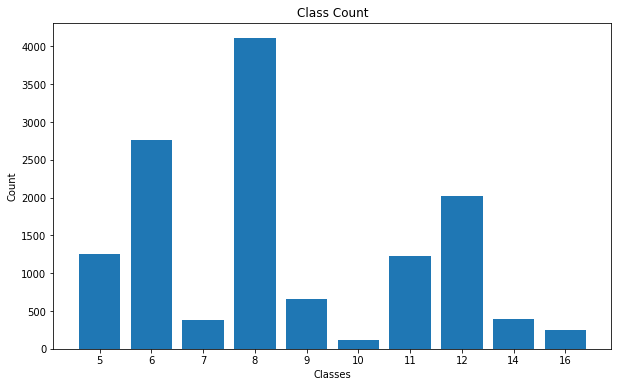

In [24]:
plot_distribution_by_class(trainset, classes)

Resnet50


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 1.4609 Acc: 0.4208
train Epoch Entropy: 2.3392
train Balanced Accuracy: 0.1752



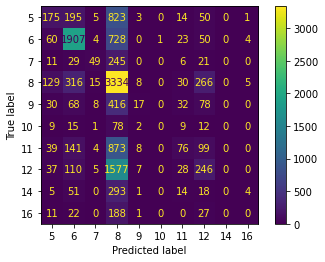

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4345 Acc: 0.4845
val Epoch Entropy: 2.1441
val Balanced Accuracy: 0.5000



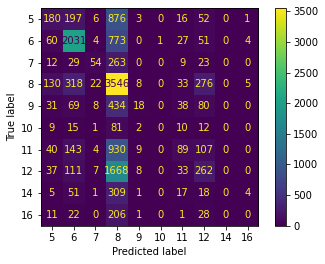

<Figure size 576x432 with 0 Axes>

Number of skipped: 216

Epoch 1/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.4147 Acc: 0.4887
train Epoch Entropy: 2.0750
train Balanced Accuracy: 0.3855



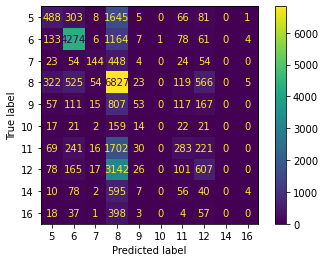

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3872 Acc: 0.5039
val Epoch Entropy: 1.9935
val Balanced Accuracy: 0.5000



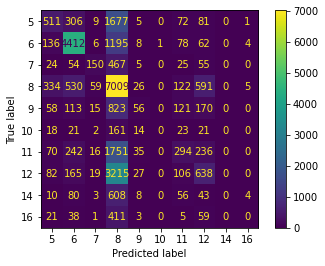

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 2/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.3663 Acc: 0.5046
train Epoch Entropy: 2.0105
train Balanced Accuracy: 0.4554



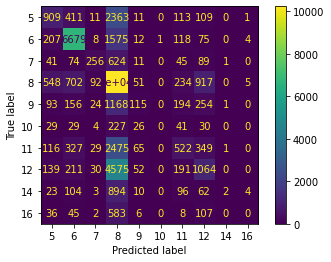

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4049 Acc: 0.5052
val Epoch Entropy: 1.9428
val Balanced Accuracy: 0.0000



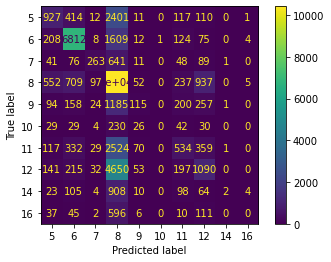

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 3/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.3411 Acc: 0.5152
train Epoch Entropy: 1.9656
train Balanced Accuracy: 0.3225



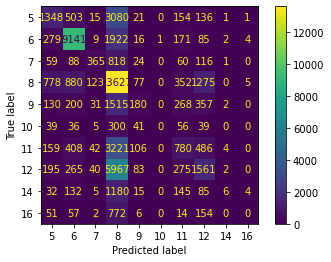

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4339 Acc: 0.4910
val Epoch Entropy: 1.9301
val Balanced Accuracy: 0.2000



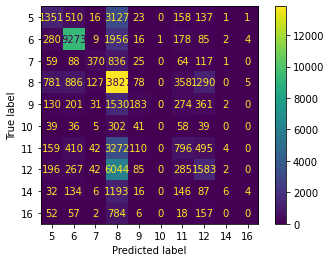

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 4/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.3107 Acc: 0.5227
train Epoch Entropy: 1.9344
train Balanced Accuracy: 0.3420



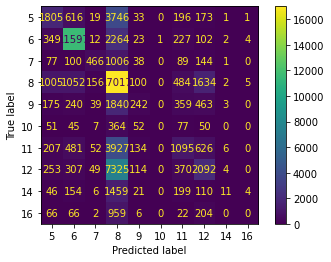

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4089 Acc: 0.5026
val Epoch Entropy: 2.0214
val Balanced Accuracy: 0.3333



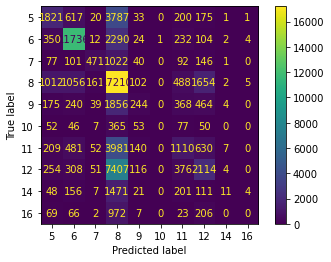

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 5/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.2824 Acc: 0.5328
train Epoch Entropy: 1.9009
train Balanced Accuracy: 0.3491



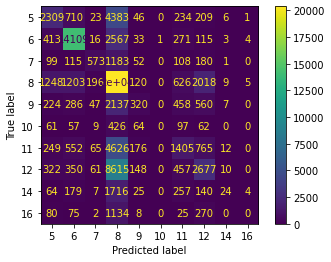

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4196 Acc: 0.5052
val Epoch Entropy: 1.8920
val Balanced Accuracy: 0.1667



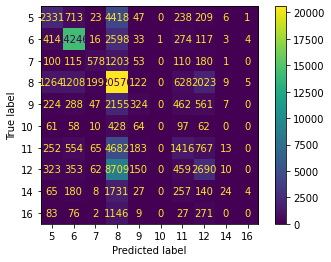

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 6/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.2529 Acc: 0.5412
train Epoch Entropy: 1.8661
train Balanced Accuracy: 0.3518



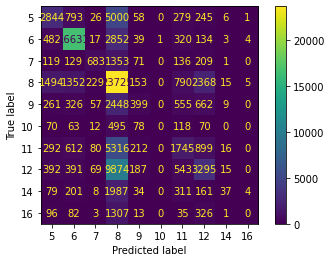

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3668 Acc: 0.5155
val Epoch Entropy: 1.9832
val Balanced Accuracy: 0.1667



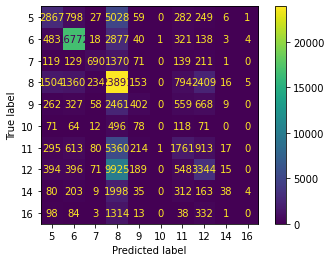

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 7/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.1083 Acc: 0.5941
train Epoch Entropy: 1.8575
train Balanced Accuracy: 0.3653



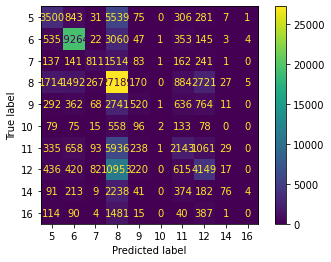

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4042 Acc: 0.5078
val Epoch Entropy: 1.8139
val Balanced Accuracy: 0.2500



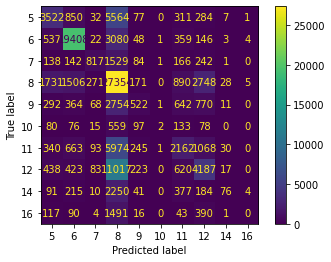

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 8/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 1.0351 Acc: 0.6277
train Epoch Entropy: 1.7450
train Balanced Accuracy: 0.5361



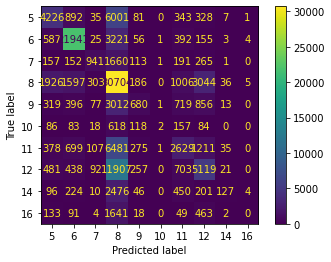

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4146 Acc: 0.5155
val Epoch Entropy: 1.7644
val Balanced Accuracy: 0.2500



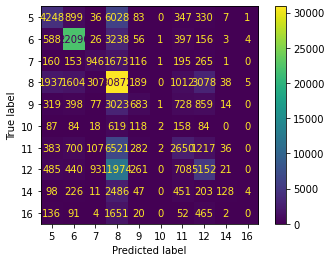

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 9/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.9721 Acc: 0.6530
train Epoch Entropy: 1.6890
train Balanced Accuracy: 0.4250



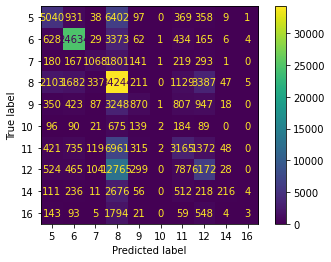

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4071 Acc: 0.5220
val Epoch Entropy: 1.6931
val Balanced Accuracy: 0.8000



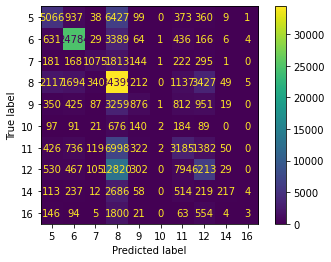

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 10/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.9064 Acc: 0.6803
train Epoch Entropy: 1.6090
train Balanced Accuracy: 0.4290



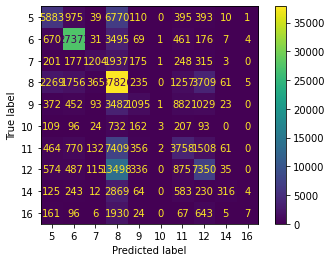

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4783 Acc: 0.5078
val Epoch Entropy: 1.6314
val Balanced Accuracy: 0.4000



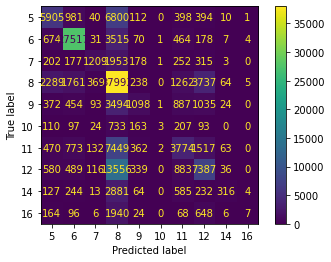

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 11/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.8419 Acc: 0.7031
train Epoch Entropy: 1.5361
train Balanced Accuracy: 0.5296



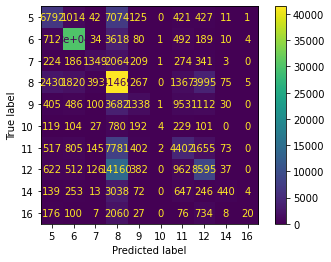

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5015 Acc: 0.5026
val Epoch Entropy: 1.6007
val Balanced Accuracy: 0.5556



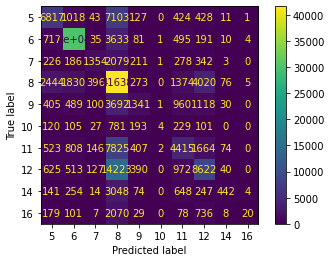

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 12/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.7738 Acc: 0.7336
train Epoch Entropy: 1.4735
train Balanced Accuracy: 0.4880



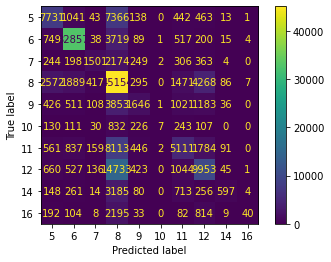

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5311 Acc: 0.4793
val Epoch Entropy: 1.5287
val Balanced Accuracy: 0.5000



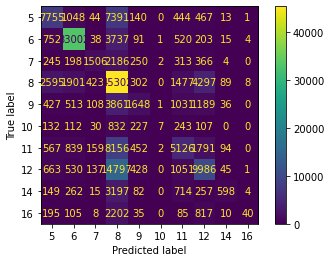

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 13/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.7089 Acc: 0.7586
train Epoch Entropy: 1.3905
train Balanced Accuracy: 0.5260



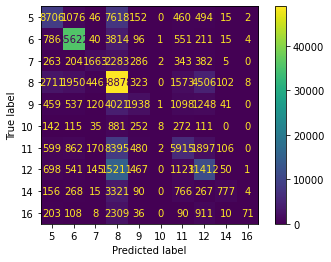

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5767 Acc: 0.4910
val Epoch Entropy: 1.4459
val Balanced Accuracy: 0.4444



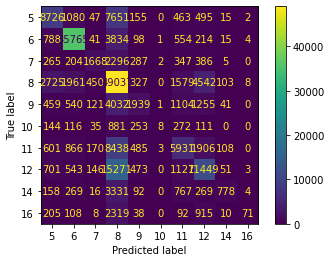

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 14/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6246 Acc: 0.7939
train Epoch Entropy: 1.3353
train Balanced Accuracy: 0.7959



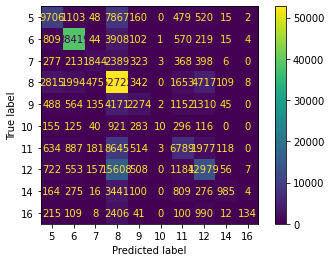

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5500 Acc: 0.5026
val Epoch Entropy: 1.5011
val Balanced Accuracy: 0.5000



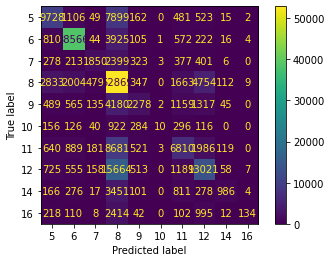

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 15/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6233 Acc: 0.7994
train Epoch Entropy: 1.3347
train Balanced Accuracy: 0.7731



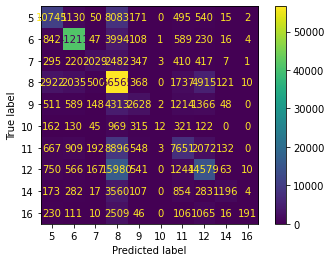

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5750 Acc: 0.4935
val Epoch Entropy: 1.4973
val Balanced Accuracy: 0.7500



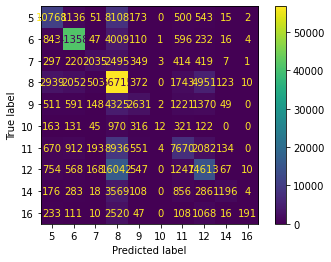

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 16/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6040 Acc: 0.8039
train Epoch Entropy: 1.3163
train Balanced Accuracy: 0.6316



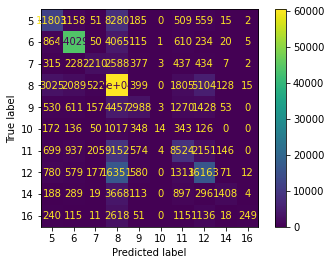

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.6104 Acc: 0.5000
val Epoch Entropy: 1.4861
val Balanced Accuracy: 0.7500



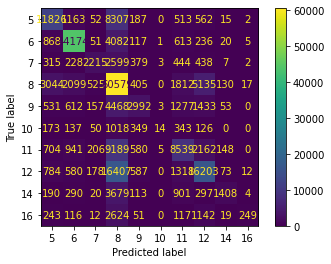

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 17/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.5987 Acc: 0.8143
train Epoch Entropy: 1.3143
train Balanced Accuracy: 0.7618



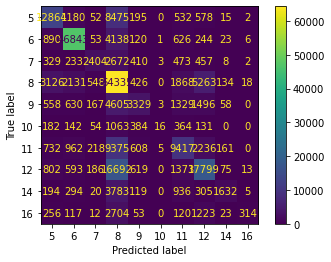

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.6096 Acc: 0.5013
val Epoch Entropy: 1.5084
val Balanced Accuracy: 0.2500



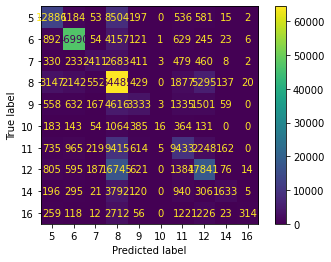

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 18/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.5924 Acc: 0.8083
train Epoch Entropy: 1.3041
train Balanced Accuracy: 0.6532



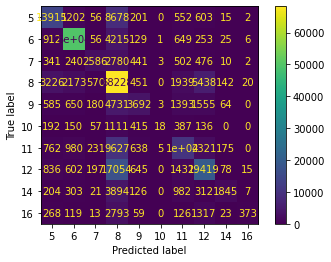

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5833 Acc: 0.4935
val Epoch Entropy: 1.4951
val Balanced Accuracy: 0.4167



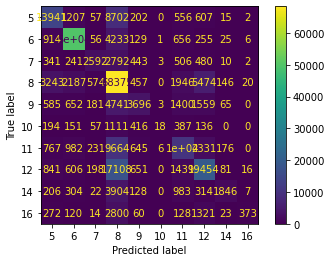

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Epoch 19/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.5851 Acc: 0.8133
train Epoch Entropy: 1.2978
train Balanced Accuracy: 0.7095



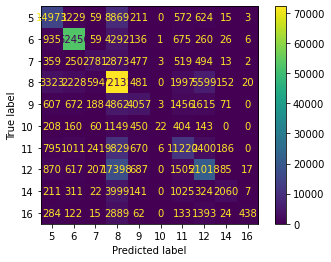

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.5944 Acc: 0.5026
val Epoch Entropy: 1.4885
val Balanced Accuracy: 0.5000



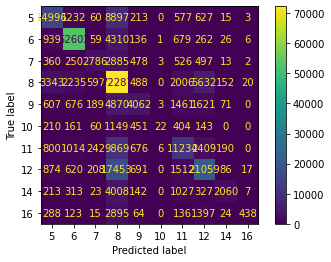

<Figure size 576x432 with 0 Axes>

Number of skipped: 219

Training complete in 34m 49s
Best val Acc: 0.521964
The Test Accuracy: tensor(0.4690, device='cuda:0')
The Test Balanced Accuracy: 0.2721009724091428


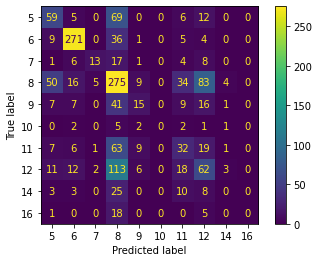

<Figure size 576x432 with 0 Axes>

None


In [12]:


model_list = []
hardness_threshold = 0.75
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=wd)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset, valset, model, criterion, optimizer, exp_lr_scheduler, num_epoch, bs,hardness_threshold)
    
    print(test_model(model, testset))





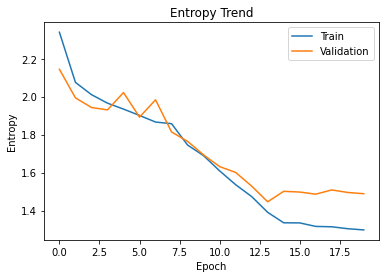

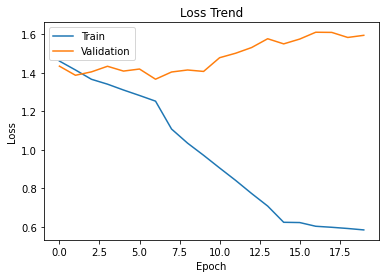

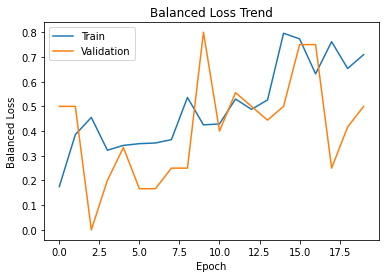

In [13]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [16]:
    
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.09290322580645162


Accuracy for SVM: 0.447741935483871
Balanced Accuracy:0.2573863385428131


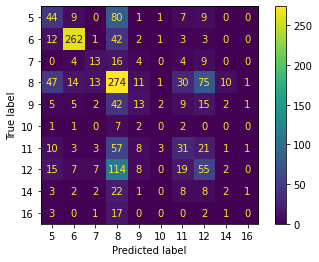

<Figure size 576x432 with 0 Axes>

In [17]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

/home/rishav/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy for MLP: 0.4432258064516129
Balanced Accuracy:0.27254580862561767


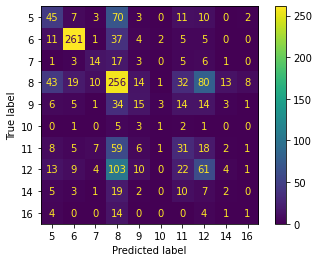

<Figure size 576x432 with 0 Axes>

In [18]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()